In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import matplotlib.image as mpimg # mpimg 用于读取图片
from sklearn.metrics import confusion_matrix

2023-02-10 14:20:30.226132: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 释放gpu内存
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

# 0. parameters

In [3]:
BATCH_SIZE = 32
BUFFER_SIZE = 300
EPOCHS = 100

# 1.Implement a data loader class to handle the downloaded data. 

In [4]:
class Dataloader():
    def __init__(self, filepath):
        h5File = h5py.File(filepath, 'r')
        self.color_codes = h5File['color_codes']
        self.rgb = h5File['rgb']
        self.seg = h5File['seg']
        
    def getitem(self, idx):
        label = self.seg[idx]
        data = self.rgb[idx]
        return data, label
    
    def __len__(self):
        return self.rgb.shape[0]

In [5]:
trainset = Dataloader("./driving_train_data.h5")
testset = Dataloader("./driving_test_data.h5")

In [6]:
# data processing
# Input:dataset,whether to crop/whether to normal
# Output:rgb after processing,seg after processing
def process_trainset(trainset,crop):
    img_train_rgb = trainset.rgb
    label_train_seg = trainset.seg
    color_train = trainset.color_codes
    if crop == True:
        concat_img = tf.concat([img_train_rgb, label_train_seg], axis=-1)
        concat_img = tf.image.resize(concat_img, (150, 300), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        crop_img = tf.image.random_crop(concat_img, [2975, 128, 256, 4])
        img_train_rgb = crop_img[:,:, :, 0:3]
        label_train_seg = crop_img[:,:, :, 3:]
    return img_train_rgb, label_train_seg, color_train

def process_testset(testset,normal):
    img_test_rgb = testset.rgb
    label_test_seg = testset.seg
    color_test = testset.color_codes
    if normal == True:
        img_test_rgb = tf.cast(img_test_rgb, tf.float32)/127.5 -1
        label_test_seg = tf.cast(label_test_seg, tf.int32)
    return img_test_rgb, label_test_seg, color_test

In [7]:
img_train_rgb, label_train_seg, color_train = process_trainset(trainset,crop = False)
img_test_rgb, label_test_seg, color_test = process_testset(testset,normal = False)

2023-02-10 14:20:32.944849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 14:20:33.563781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:40:00.0, compute capability: 8.6


((128, 256, 3), (128, 256, 1))

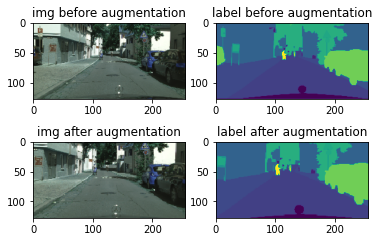

In [8]:
# test train images after augmentation
# 建议跳过这一段
# you can just ignore this part
img_1,label_1,color_1 = process_trainset(trainset,crop = True)
# reset_keras()
plt.subplot(2,2,1)
plt.title('img before augmentation')
plt.imshow(img_train_rgb[1])
plt.subplot(2,2,2)
plt.title('label before augmentation')
plt.imshow(label_train_seg[1])
plt.subplot(2,2,3)
plt.title('img after augmentation')
plt.imshow(img_1[1])
plt.subplot(2,2,4)
plt.title('label after augmentation')
plt.imshow(label_1[1])
img_1.shape, label_1.shape
img_train_rgb[1].shape,label_train_seg[1].shape

In [9]:
# reset_keras()
index = np.random.permutation(len(img_train_rgb))
train_images = np.array(img_train_rgb)[index]
train_labels = np.array(label_train_seg)[index]
val_images = img_test_rgb
val_labels = label_test_seg

train_count = len(trainset)
val_count = len(testset)
train_step_per_epoch = train_count // BATCH_SIZE
val_step_per_epoch = val_count // BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE



#create dataset for training the model
dataset_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset_val = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

dataset_train = dataset_train.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
dataset_val = dataset_val.cache().batch(BATCH_SIZE)

2023-02-10 14:20:36.880361: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


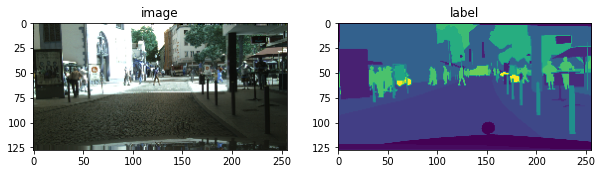

In [10]:
for image, label in dataset_val.take(1):
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.title('image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(122)
    plt.title('label')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(label[0]))

# 2. Define the model. Provide a schematic of your architecture depicting its overall structure and the relevant parameters.

## 2.1 Create the model

We use U-Net as our model architecture

In [11]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(128, 256, 3))
    print('input shape:',inputs.shape)
    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)    
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    print('x shape after first 2conv layers:',x.shape)
    
    x1 = tf.keras.layers.MaxPooling2D(padding='same')(x)
    print('x1 shape after first maxpooling layer:',x1.shape)
    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)    
    x1 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x1)
    x1= tf.keras.layers.BatchNormalization()(x1)
    print('x1 shape after next 2 conv layers:',x1.shape)
        
    x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1)
    print('x2 shape after next maxpooling layer:',x2.shape)
    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)    
    x2 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x2)
    x2= tf.keras.layers.BatchNormalization()(x2)
    print('x2 shape after next 2 conv layers:',x2.shape) 
    
    x3 = tf.keras.layers.MaxPooling2D(padding='same')(x2)
    print('x3 shape after next maxpooling layer:',x3.shape)
    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)    
    x3 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    print('x3 shape after next 2 conv layers:',x3.shape)  
    
    x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3)
    print('x4 shape after next maxpooling layer:',x4.shape)
    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)    
    x4 = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu')(x4)
    x4= tf.keras.layers.BatchNormalization()(x4)
    print('x4 shape after next 2 conv layers:',x4.shape)   
    
    # 上采样
    x5 = tf.keras.layers.Conv2DTranspose(512, 2, strides=2, padding='same',
                                         activation='relu')(x4)
    x5 = tf.keras.layers.BatchNormalization()(x5)
    print('x5 shape after first upsampling layer:',x5.shape)
    
    x6 = tf.concat([x3, x5], axis=-1)
    print('x6 shape after 1st concatenating layer:',x6.shape)
    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)    
    x6 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x6)
    x6= tf.keras.layers.BatchNormalization()(x6)
    print('x6 shape after next 2 conv layers:',x6.shape)
    
    x7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same',
                                        activation='relu')(x6)
    x7 = tf.keras.layers.BatchNormalization()(x7)
    print('x7 shape after 2nd upsampling layer:',x7.shape)
    x8 = tf.concat([x2, x7], axis=-1)
    print('x8 shape after 2nd concatenating layer:',x6.shape)
    
    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)    
    x8 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x8)
    x8= tf.keras.layers.BatchNormalization()(x8)
    print('x8 shape after next 2 conv layers:',x8.shape)
    
    x9= tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same',
                                        activation='relu')(x8)
    x9 = tf.keras.layers.BatchNormalization()(x9)
    print('x9 shape after 3rd upsampling layer:',x9.shape)
    
    x10 = tf.concat([x1, x9], axis=-1)
    print('x10 shape after 3rd concatenating layer:',x10.shape)
    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)    
    x10 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    print('x10 shape after next 2 conv layers:',x10.shape)
    
    
    x11= tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same',
                                        activation='relu')(x10)
    x11 = tf.keras.layers.BatchNormalization()(x11)
    print('x11 shape after 4th upsampling layer:',x11.shape)
    x12 = tf.concat([x, x11], axis=-1)
    print('x12 shape after 4th concatenating layer:',x12.shape)
    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x11)
    x12 = tf.keras.layers.BatchNormalization()(x12)    
    x12 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    print('x12 shape after next 2 conv layers:',x12.shape)
    
    output = tf.keras.layers.Conv2D(34, 1, padding='same', activation='softmax')(x12)
    print('final output shape',x12.shape)

    
    return tf.keras.Model(inputs=inputs, outputs=output)

model = create_model()
model.summary()

input shape: (None, 128, 256, 3)
x shape after first 2conv layers: (None, 128, 256, 64)
x1 shape after first maxpooling layer: (None, 64, 128, 64)
x1 shape after next 2 conv layers: (None, 64, 128, 128)
x2 shape after next maxpooling layer: (None, 32, 64, 128)
x2 shape after next 2 conv layers: (None, 32, 64, 256)
x3 shape after next maxpooling layer: (None, 16, 32, 256)
x3 shape after next 2 conv layers: (None, 16, 32, 512)
x4 shape after next maxpooling layer: (None, 8, 16, 512)
x4 shape after next 2 conv layers: (None, 8, 16, 1024)
x5 shape after first upsampling layer: (None, 16, 32, 512)
x6 shape after 1st concatenating layer: (None, 16, 32, 1024)
x6 shape after next 2 conv layers: (None, 16, 32, 512)
x7 shape after 2nd upsampling layer: (None, 32, 64, 256)
x8 shape after 2nd concatenating layer: (None, 16, 32, 512)
x8 shape after next 2 conv layers: (None, 32, 64, 256)
x9 shape after 3rd upsampling layer: (None, 64, 128, 128)
x10 shape after 3rd concatenating layer: (None, 64, 12

## 2.2 Provide a schematic of your architecture depicting its overall structure and the relevant parameters.

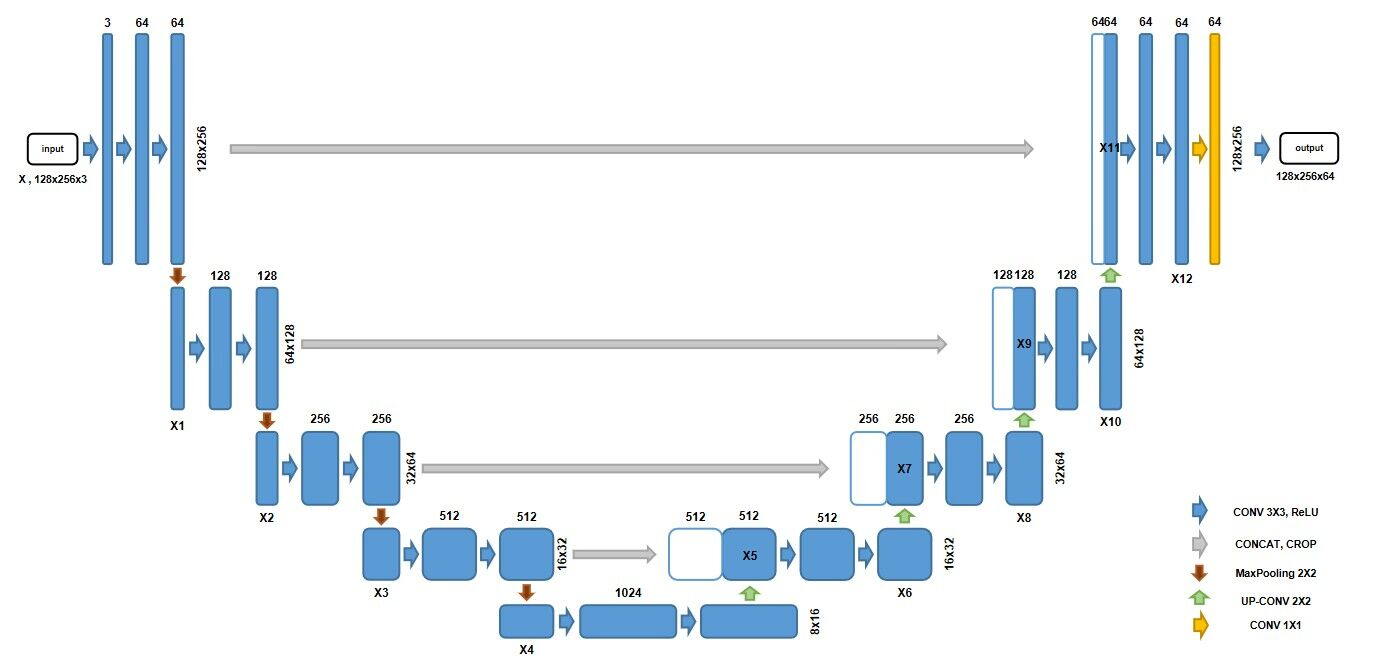

# 3. Define the loss function and optimizer. 

In [12]:
optimizer='adam'
loss='sparse_categorical_crossentropy'

In [13]:
#定义平均iou函数
class MeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
        
#编译模型        
model.compile(optimizer=optimizer, loss=loss, metrics=['acc',MeanIoU(num_classes=34)])

# 4. Train the network.

In [14]:
# reset_keras()
history = model.fit(dataset_train, epochs=EPOCHS, 
                   steps_per_epoch=train_step_per_epoch,
                   validation_steps=val_step_per_epoch,
                   validation_data=dataset_val)

Epoch 1/100


2023-02-10 14:20:41.030194: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


92/92 [==============================] - 29s 233ms/step - loss: 1.1847 - acc: 0.7038 - mean_io_u: 0.1414 - val_loss: 2.2591 - val_acc: 0.4019 - val_mean_io_u: 0.0574
Epoch 2/100
 1/92 [..............................] - ETA: 17s - loss: 0.9090 - acc: 0.7639 - mean_io_u: 0.1815

2023-02-10 14:21:06.214994: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 18s 201ms/step - loss: 0.7711 - acc: 0.7964 - mean_io_u: 0.2047 - val_loss: 1.0833 - val_acc: 0.7350 - val_mean_io_u: 0.1584
Epoch 3/100
 1/92 [..............................] - ETA: 17s - loss: 0.6693 - acc: 0.8197 - mean_io_u: 0.2261

2023-02-10 14:21:24.665835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 18s 201ms/step - loss: 0.6800 - acc: 0.8184 - mean_io_u: 0.2286 - val_loss: 0.8552 - val_acc: 0.7849 - val_mean_io_u: 0.1890
Epoch 4/100
 1/92 [..............................] - ETA: 17s - loss: 0.6048 - acc: 0.8382 - mean_io_u: 0.2493

2023-02-10 14:21:43.149418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.6276 - acc: 0.8316 - mean_io_u: 0.2474 - val_loss: 0.7662 - val_acc: 0.8012 - val_mean_io_u: 0.2362
Epoch 5/100
 1/92 [..............................] - ETA: 17s - loss: 0.6010 - acc: 0.8312 - mean_io_u: 0.2555

2023-02-10 14:22:01.742796: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.5797 - acc: 0.8420 - mean_io_u: 0.2644 - val_loss: 0.6888 - val_acc: 0.8147 - val_mean_io_u: 0.2458
Epoch 6/100
 1/92 [..............................] - ETA: 17s - loss: 0.5505 - acc: 0.8499 - mean_io_u: 0.2724

2023-02-10 14:22:20.318780: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.5532 - acc: 0.8483 - mean_io_u: 0.2741 - val_loss: 0.7322 - val_acc: 0.8233 - val_mean_io_u: 0.2504
Epoch 7/100
 1/92 [..............................] - ETA: 17s - loss: 0.5471 - acc: 0.8498 - mean_io_u: 0.2734

2023-02-10 14:22:38.900254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.5351 - acc: 0.8513 - mean_io_u: 0.2853 - val_loss: 0.7706 - val_acc: 0.7970 - val_mean_io_u: 0.2418
Epoch 8/100


2023-02-10 14:22:57.481931: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.5039 - acc: 0.8592 - mean_io_u: 0.2986 - val_loss: 0.6446 - val_acc: 0.8271 - val_mean_io_u: 0.2652
Epoch 9/100
 1/92 [..............................] - ETA: 17s - loss: 0.4960 - acc: 0.8598 - mean_io_u: 0.2947

2023-02-10 14:23:16.067555: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4815 - acc: 0.8646 - mean_io_u: 0.3139 - val_loss: 0.6130 - val_acc: 0.8320 - val_mean_io_u: 0.2798
Epoch 10/100
 1/92 [..............................] - ETA: 17s - loss: 0.4848 - acc: 0.8614 - mean_io_u: 0.3057

2023-02-10 14:23:34.647369: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4697 - acc: 0.8671 - mean_io_u: 0.3234 - val_loss: 0.5866 - val_acc: 0.8393 - val_mean_io_u: 0.2835
Epoch 11/100
 1/92 [..............................] - ETA: 17s - loss: 0.4932 - acc: 0.8607 - mean_io_u: 0.3185

2023-02-10 14:23:53.215934: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4616 - acc: 0.8692 - mean_io_u: 0.3316 - val_loss: 0.6599 - val_acc: 0.8085 - val_mean_io_u: 0.2886
Epoch 12/100
 1/92 [..............................] - ETA: 17s - loss: 0.4743 - acc: 0.8595 - mean_io_u: 0.3086

2023-02-10 14:24:11.787891: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4364 - acc: 0.8755 - mean_io_u: 0.3454 - val_loss: 0.6118 - val_acc: 0.8358 - val_mean_io_u: 0.2816
Epoch 13/100
 1/92 [..............................] - ETA: 17s - loss: 0.4141 - acc: 0.8835 - mean_io_u: 0.3489

2023-02-10 14:24:30.349349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4207 - acc: 0.8792 - mean_io_u: 0.3580 - val_loss: 0.5819 - val_acc: 0.8339 - val_mean_io_u: 0.3068
Epoch 14/100
 1/92 [..............................] - ETA: 17s - loss: 0.4099 - acc: 0.8734 - mean_io_u: 0.3377

2023-02-10 14:24:48.926409: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.4080 - acc: 0.8827 - mean_io_u: 0.3691 - val_loss: 0.6035 - val_acc: 0.8444 - val_mean_io_u: 0.2929
Epoch 15/100
 1/92 [..............................] - ETA: 17s - loss: 0.3428 - acc: 0.9046 - mean_io_u: 0.3731

2023-02-10 14:25:07.489470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3894 - acc: 0.8883 - mean_io_u: 0.3822 - val_loss: 0.5929 - val_acc: 0.8500 - val_mean_io_u: 0.2954
Epoch 16/100
 1/92 [..............................] - ETA: 17s - loss: 0.3598 - acc: 0.8971 - mean_io_u: 0.3358

2023-02-10 14:25:26.052016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3943 - acc: 0.8863 - mean_io_u: 0.3841 - val_loss: 0.6030 - val_acc: 0.8503 - val_mean_io_u: 0.3017
Epoch 17/100
 1/92 [..............................] - ETA: 17s - loss: 0.3394 - acc: 0.9011 - mean_io_u: 0.3897

2023-02-10 14:25:44.617835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3755 - acc: 0.8921 - mean_io_u: 0.3992 - val_loss: 0.5823 - val_acc: 0.8466 - val_mean_io_u: 0.3055
Epoch 18/100
 1/92 [..............................] - ETA: 17s - loss: 0.3337 - acc: 0.9040 - mean_io_u: 0.3416

2023-02-10 14:26:03.175005: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3586 - acc: 0.8962 - mean_io_u: 0.4113 - val_loss: 0.5998 - val_acc: 0.8551 - val_mean_io_u: 0.3130
Epoch 19/100
 1/92 [..............................] - ETA: 17s - loss: 0.4827 - acc: 0.8601 - mean_io_u: 0.3541

2023-02-10 14:26:21.730073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3514 - acc: 0.8986 - mean_io_u: 0.4232 - val_loss: 0.5569 - val_acc: 0.8566 - val_mean_io_u: 0.3256
Epoch 20/100
 1/92 [..............................] - ETA: 17s - loss: 0.3185 - acc: 0.9104 - mean_io_u: 0.4461

2023-02-10 14:26:40.279290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3376 - acc: 0.9026 - mean_io_u: 0.4366 - val_loss: 0.5145 - val_acc: 0.8596 - val_mean_io_u: 0.3400
Epoch 21/100
 1/92 [..............................] - ETA: 17s - loss: 0.3355 - acc: 0.8997 - mean_io_u: 0.3619

2023-02-10 14:26:58.828108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3239 - acc: 0.9065 - mean_io_u: 0.4477 - val_loss: 0.5210 - val_acc: 0.8607 - val_mean_io_u: 0.3383
Epoch 22/100
 1/92 [..............................] - ETA: 17s - loss: 0.2862 - acc: 0.9189 - mean_io_u: 0.4276

2023-02-10 14:27:17.383820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3207 - acc: 0.9075 - mean_io_u: 0.4503 - val_loss: 0.5704 - val_acc: 0.8491 - val_mean_io_u: 0.3309
Epoch 23/100
 1/92 [..............................] - ETA: 17s - loss: 0.3225 - acc: 0.9044 - mean_io_u: 0.4199

2023-02-10 14:27:35.929539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.3068 - acc: 0.9117 - mean_io_u: 0.4681 - val_loss: 0.5570 - val_acc: 0.8575 - val_mean_io_u: 0.3406
Epoch 24/100
 1/92 [..............................] - ETA: 17s - loss: 0.3161 - acc: 0.9056 - mean_io_u: 0.4338

2023-02-10 14:27:54.486957: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2921 - acc: 0.9159 - mean_io_u: 0.4934 - val_loss: 0.4975 - val_acc: 0.8703 - val_mean_io_u: 0.3564
Epoch 25/100
 1/92 [..............................] - ETA: 17s - loss: 0.2861 - acc: 0.9178 - mean_io_u: 0.4505

2023-02-10 14:28:13.033116: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2849 - acc: 0.9181 - mean_io_u: 0.4999 - val_loss: 0.6327 - val_acc: 0.8298 - val_mean_io_u: 0.3189
Epoch 26/100
 1/92 [..............................] - ETA: 17s - loss: 0.3191 - acc: 0.9081 - mean_io_u: 0.4011

2023-02-10 14:28:31.603934: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2922 - acc: 0.9154 - mean_io_u: 0.4926 - val_loss: 0.5348 - val_acc: 0.8644 - val_mean_io_u: 0.3516
Epoch 27/100


2023-02-10 14:28:50.148969: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2856 - acc: 0.9175 - mean_io_u: 0.5065 - val_loss: 0.5773 - val_acc: 0.8546 - val_mean_io_u: 0.3462
Epoch 28/100
 1/92 [..............................] - ETA: 17s - loss: 0.2634 - acc: 0.9244 - mean_io_u: 0.4888

2023-02-10 14:29:08.699399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2718 - acc: 0.9216 - mean_io_u: 0.5219 - val_loss: 0.5795 - val_acc: 0.8486 - val_mean_io_u: 0.3413
Epoch 29/100
 1/92 [..............................] - ETA: 17s - loss: 0.2702 - acc: 0.9236 - mean_io_u: 0.4473

2023-02-10 14:29:27.249299: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2578 - acc: 0.9260 - mean_io_u: 0.5415 - val_loss: 0.5229 - val_acc: 0.8681 - val_mean_io_u: 0.3612
Epoch 30/100
 1/92 [..............................] - ETA: 17s - loss: 0.2608 - acc: 0.9228 - mean_io_u: 0.5015

2023-02-10 14:29:45.803495: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2414 - acc: 0.9310 - mean_io_u: 0.5610 - val_loss: 0.5414 - val_acc: 0.8674 - val_mean_io_u: 0.3542
Epoch 31/100
 1/92 [..............................] - ETA: 17s - loss: 0.2549 - acc: 0.9265 - mean_io_u: 0.5140

2023-02-10 14:30:04.361173: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2312 - acc: 0.9341 - mean_io_u: 0.5763 - val_loss: 0.5054 - val_acc: 0.8735 - val_mean_io_u: 0.3682
Epoch 32/100
 1/92 [..............................] - ETA: 17s - loss: 0.2388 - acc: 0.9324 - mean_io_u: 0.5200

2023-02-10 14:30:22.912090: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2196 - acc: 0.9374 - mean_io_u: 0.5918 - val_loss: 0.5251 - val_acc: 0.8674 - val_mean_io_u: 0.3627
Epoch 33/100
 1/92 [..............................] - ETA: 17s - loss: 0.2047 - acc: 0.9403 - mean_io_u: 0.5073

2023-02-10 14:30:41.465571: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2159 - acc: 0.9383 - mean_io_u: 0.6009 - val_loss: 0.5289 - val_acc: 0.8684 - val_mean_io_u: 0.3604
Epoch 34/100
 1/92 [..............................] - ETA: 17s - loss: 0.2167 - acc: 0.9392 - mean_io_u: 0.5129

2023-02-10 14:31:00.021069: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2138 - acc: 0.9387 - mean_io_u: 0.5973 - val_loss: 0.5464 - val_acc: 0.8719 - val_mean_io_u: 0.3602
Epoch 35/100
 1/92 [..............................] - ETA: 17s - loss: 0.2094 - acc: 0.9400 - mean_io_u: 0.5303

2023-02-10 14:31:18.572867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2135 - acc: 0.9387 - mean_io_u: 0.6046 - val_loss: 0.5610 - val_acc: 0.8688 - val_mean_io_u: 0.3615
Epoch 36/100
 1/92 [..............................] - ETA: 17s - loss: 0.2073 - acc: 0.9412 - mean_io_u: 0.5187

2023-02-10 14:31:37.130499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2087 - acc: 0.9402 - mean_io_u: 0.6109 - val_loss: 0.5596 - val_acc: 0.8714 - val_mean_io_u: 0.3635
Epoch 37/100


2023-02-10 14:31:55.686412: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2206 - acc: 0.9365 - mean_io_u: 0.6089 - val_loss: 0.6505 - val_acc: 0.8493 - val_mean_io_u: 0.3435
Epoch 38/100
 1/92 [..............................] - ETA: 17s - loss: 0.2017 - acc: 0.9414 - mean_io_u: 0.4716

2023-02-10 14:32:14.240197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2576 - acc: 0.9252 - mean_io_u: 0.5556 - val_loss: 0.6357 - val_acc: 0.8600 - val_mean_io_u: 0.3399
Epoch 39/100
 1/92 [..............................] - ETA: 17s - loss: 0.2514 - acc: 0.9267 - mean_io_u: 0.4390

2023-02-10 14:32:32.788645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2382 - acc: 0.9311 - mean_io_u: 0.5713 - val_loss: 0.5761 - val_acc: 0.8708 - val_mean_io_u: 0.3551
Epoch 40/100
 1/92 [..............................] - ETA: 17s - loss: 0.2233 - acc: 0.9382 - mean_io_u: 0.5261

2023-02-10 14:32:51.329818: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2101 - acc: 0.9397 - mean_io_u: 0.6253 - val_loss: 0.5443 - val_acc: 0.8731 - val_mean_io_u: 0.3642
Epoch 41/100
 1/92 [..............................] - ETA: 17s - loss: 0.2097 - acc: 0.9405 - mean_io_u: 0.5555

2023-02-10 14:33:09.886235: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1940 - acc: 0.9444 - mean_io_u: 0.6365 - val_loss: 0.5487 - val_acc: 0.8713 - val_mean_io_u: 0.3683
Epoch 42/100
 1/92 [..............................] - ETA: 17s - loss: 0.1715 - acc: 0.9500 - mean_io_u: 0.5738

2023-02-10 14:33:28.439550: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1823 - acc: 0.9479 - mean_io_u: 0.6617 - val_loss: 0.5369 - val_acc: 0.8752 - val_mean_io_u: 0.3705
Epoch 43/100
 1/92 [..............................] - ETA: 17s - loss: 0.1817 - acc: 0.9479 - mean_io_u: 0.5788

2023-02-10 14:33:46.984742: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1744 - acc: 0.9502 - mean_io_u: 0.6808 - val_loss: 0.5408 - val_acc: 0.8765 - val_mean_io_u: 0.3735
Epoch 44/100
 1/92 [..............................] - ETA: 17s - loss: 0.1538 - acc: 0.9556 - mean_io_u: 0.5639

2023-02-10 14:34:05.536725: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1694 - acc: 0.9515 - mean_io_u: 0.6850 - val_loss: 0.5534 - val_acc: 0.8720 - val_mean_io_u: 0.3720
Epoch 45/100
 1/92 [..............................] - ETA: 17s - loss: 0.1549 - acc: 0.9551 - mean_io_u: 0.5553

2023-02-10 14:34:24.082294: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1656 - acc: 0.9526 - mean_io_u: 0.7017 - val_loss: 0.5651 - val_acc: 0.8752 - val_mean_io_u: 0.3665
Epoch 46/100
 1/92 [..............................] - ETA: 17s - loss: 0.1663 - acc: 0.9528 - mean_io_u: 0.5930

2023-02-10 14:34:42.669254: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1603 - acc: 0.9541 - mean_io_u: 0.7004 - val_loss: 0.5666 - val_acc: 0.8761 - val_mean_io_u: 0.3730
Epoch 47/100
 1/92 [..............................] - ETA: 17s - loss: 0.1617 - acc: 0.9532 - mean_io_u: 0.6836

2023-02-10 14:35:01.228175: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1592 - acc: 0.9543 - mean_io_u: 0.7116 - val_loss: 0.6029 - val_acc: 0.8731 - val_mean_io_u: 0.3654
Epoch 48/100
 1/92 [..............................] - ETA: 17s - loss: 0.1577 - acc: 0.9544 - mean_io_u: 0.5997

2023-02-10 14:35:19.770033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1526 - acc: 0.9562 - mean_io_u: 0.7215 - val_loss: 0.5796 - val_acc: 0.8736 - val_mean_io_u: 0.3725
Epoch 49/100
 1/92 [..............................] - ETA: 17s - loss: 0.1481 - acc: 0.9576 - mean_io_u: 0.6155

2023-02-10 14:35:38.316000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1509 - acc: 0.9566 - mean_io_u: 0.7174 - val_loss: 0.5832 - val_acc: 0.8770 - val_mean_io_u: 0.3751
Epoch 50/100
 1/92 [..............................] - ETA: 17s - loss: 0.1275 - acc: 0.9634 - mean_io_u: 0.5688

2023-02-10 14:35:56.872982: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1479 - acc: 0.9574 - mean_io_u: 0.7316 - val_loss: 0.5905 - val_acc: 0.8740 - val_mean_io_u: 0.3736
Epoch 51/100
 1/92 [..............................] - ETA: 17s - loss: 0.1442 - acc: 0.9579 - mean_io_u: 0.5831

2023-02-10 14:36:15.426778: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1462 - acc: 0.9579 - mean_io_u: 0.7234 - val_loss: 0.6148 - val_acc: 0.8736 - val_mean_io_u: 0.3710
Epoch 52/100
 1/92 [..............................] - ETA: 17s - loss: 0.1412 - acc: 0.9586 - mean_io_u: 0.6325

2023-02-10 14:36:33.976432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1448 - acc: 0.9581 - mean_io_u: 0.7308 - val_loss: 0.6416 - val_acc: 0.8741 - val_mean_io_u: 0.3697
Epoch 53/100
 1/92 [..............................] - ETA: 17s - loss: 0.1405 - acc: 0.9599 - mean_io_u: 0.5977

2023-02-10 14:36:52.528162: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1433 - acc: 0.9586 - mean_io_u: 0.7312 - val_loss: 0.6100 - val_acc: 0.8731 - val_mean_io_u: 0.3756
Epoch 54/100
 1/92 [..............................] - ETA: 17s - loss: 0.1312 - acc: 0.9629 - mean_io_u: 0.5601

2023-02-10 14:37:11.071331: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1441 - acc: 0.9582 - mean_io_u: 0.7284 - val_loss: 0.6269 - val_acc: 0.8739 - val_mean_io_u: 0.3687
Epoch 55/100
 1/92 [..............................] - ETA: 17s - loss: 0.1471 - acc: 0.9579 - mean_io_u: 0.6117

2023-02-10 14:37:29.617841: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1395 - acc: 0.9596 - mean_io_u: 0.7320 - val_loss: 0.6411 - val_acc: 0.8734 - val_mean_io_u: 0.3668
Epoch 56/100
 1/92 [..............................] - ETA: 17s - loss: 0.1279 - acc: 0.9629 - mean_io_u: 0.6169

2023-02-10 14:37:48.162640: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1400 - acc: 0.9593 - mean_io_u: 0.7339 - val_loss: 0.6736 - val_acc: 0.8733 - val_mean_io_u: 0.3651
Epoch 57/100
 1/92 [..............................] - ETA: 17s - loss: 0.1294 - acc: 0.9626 - mean_io_u: 0.6272

2023-02-10 14:38:06.706286: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1453 - acc: 0.9580 - mean_io_u: 0.7279 - val_loss: 1.4358 - val_acc: 0.7485 - val_mean_io_u: 0.2383
Epoch 58/100
 1/92 [..............................] - ETA: 17s - loss: 0.1947 - acc: 0.9432 - mean_io_u: 0.5830

2023-02-10 14:38:25.251406: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2679 - acc: 0.9220 - mean_io_u: 0.5454 - val_loss: 1.1159 - val_acc: 0.8225 - val_mean_io_u: 0.3027
Epoch 59/100
 1/92 [..............................] - ETA: 17s - loss: 0.3201 - acc: 0.9085 - mean_io_u: 0.4652

2023-02-10 14:38:43.794317: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2758 - acc: 0.9202 - mean_io_u: 0.5151 - val_loss: 0.6727 - val_acc: 0.8543 - val_mean_io_u: 0.3386
Epoch 60/100
 1/92 [..............................] - ETA: 17s - loss: 0.2219 - acc: 0.9349 - mean_io_u: 0.4777

2023-02-10 14:39:02.336606: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2065 - acc: 0.9398 - mean_io_u: 0.5906 - val_loss: 0.5675 - val_acc: 0.8681 - val_mean_io_u: 0.3685
Epoch 61/100
 1/92 [..............................] - ETA: 17s - loss: 0.1940 - acc: 0.9433 - mean_io_u: 0.5649

2023-02-10 14:39:20.886966: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1675 - acc: 0.9514 - mean_io_u: 0.6875 - val_loss: 0.5374 - val_acc: 0.8732 - val_mean_io_u: 0.3819
Epoch 62/100
 1/92 [..............................] - ETA: 17s - loss: 0.1566 - acc: 0.9542 - mean_io_u: 0.6040

2023-02-10 14:39:39.426274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1460 - acc: 0.9577 - mean_io_u: 0.7257 - val_loss: 0.5505 - val_acc: 0.8771 - val_mean_io_u: 0.3814
Epoch 63/100
 1/92 [..............................] - ETA: 17s - loss: 0.1408 - acc: 0.9588 - mean_io_u: 0.6147

2023-02-10 14:39:58.003553: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1371 - acc: 0.9604 - mean_io_u: 0.7448 - val_loss: 0.5766 - val_acc: 0.8774 - val_mean_io_u: 0.3813
Epoch 64/100
 1/92 [..............................] - ETA: 17s - loss: 0.1304 - acc: 0.9623 - mean_io_u: 0.5885

2023-02-10 14:40:16.547337: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1318 - acc: 0.9619 - mean_io_u: 0.7505 - val_loss: 0.5918 - val_acc: 0.8763 - val_mean_io_u: 0.3771
Epoch 65/100
 1/92 [..............................] - ETA: 17s - loss: 0.1238 - acc: 0.9643 - mean_io_u: 0.6378

2023-02-10 14:40:35.091458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1266 - acc: 0.9633 - mean_io_u: 0.7566 - val_loss: 0.6027 - val_acc: 0.8758 - val_mean_io_u: 0.3783
Epoch 66/100
 1/92 [..............................] - ETA: 17s - loss: 0.1191 - acc: 0.9652 - mean_io_u: 0.6112

2023-02-10 14:40:53.642428: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1245 - acc: 0.9639 - mean_io_u: 0.7592 - val_loss: 0.6163 - val_acc: 0.8768 - val_mean_io_u: 0.3801
Epoch 67/100
 1/92 [..............................] - ETA: 17s - loss: 0.1301 - acc: 0.9616 - mean_io_u: 0.6403

2023-02-10 14:41:12.214890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1217 - acc: 0.9646 - mean_io_u: 0.7610 - val_loss: 0.6320 - val_acc: 0.8755 - val_mean_io_u: 0.3787
Epoch 68/100
 1/92 [..............................] - ETA: 17s - loss: 0.1257 - acc: 0.9634 - mean_io_u: 0.6858

2023-02-10 14:41:30.772087: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1201 - acc: 0.9651 - mean_io_u: 0.7629 - val_loss: 0.6397 - val_acc: 0.8742 - val_mean_io_u: 0.3758
Epoch 69/100
 1/92 [..............................] - ETA: 17s - loss: 0.1320 - acc: 0.9619 - mean_io_u: 0.6578

2023-02-10 14:41:49.325089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1168 - acc: 0.9661 - mean_io_u: 0.7657 - val_loss: 0.6419 - val_acc: 0.8770 - val_mean_io_u: 0.3763
Epoch 70/100
 1/92 [..............................] - ETA: 17s - loss: 0.1139 - acc: 0.9669 - mean_io_u: 0.6144

2023-02-10 14:42:07.877122: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1153 - acc: 0.9665 - mean_io_u: 0.7666 - val_loss: 0.6486 - val_acc: 0.8755 - val_mean_io_u: 0.3779
Epoch 71/100
 1/92 [..............................] - ETA: 17s - loss: 0.1154 - acc: 0.9666 - mean_io_u: 0.6456

2023-02-10 14:42:26.434987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1139 - acc: 0.9668 - mean_io_u: 0.7705 - val_loss: 0.6485 - val_acc: 0.8753 - val_mean_io_u: 0.3794
Epoch 72/100
 1/92 [..............................] - ETA: 17s - loss: 0.1065 - acc: 0.9687 - mean_io_u: 0.6136

2023-02-10 14:42:44.988810: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1133 - acc: 0.9669 - mean_io_u: 0.7689 - val_loss: 0.6687 - val_acc: 0.8757 - val_mean_io_u: 0.3759
Epoch 73/100
 1/92 [..............................] - ETA: 17s - loss: 0.1069 - acc: 0.9691 - mean_io_u: 0.6378

2023-02-10 14:43:03.554519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1109 - acc: 0.9676 - mean_io_u: 0.7715 - val_loss: 0.6698 - val_acc: 0.8753 - val_mean_io_u: 0.3756
Epoch 74/100
 1/92 [..............................] - ETA: 17s - loss: 0.1055 - acc: 0.9690 - mean_io_u: 0.6598

2023-02-10 14:43:22.143698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1108 - acc: 0.9676 - mean_io_u: 0.7733 - val_loss: 0.6696 - val_acc: 0.8749 - val_mean_io_u: 0.3784
Epoch 75/100
 1/92 [..............................] - ETA: 17s - loss: 0.1104 - acc: 0.9680 - mean_io_u: 0.6482

2023-02-10 14:43:40.698201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1089 - acc: 0.9681 - mean_io_u: 0.7748 - val_loss: 0.6746 - val_acc: 0.8735 - val_mean_io_u: 0.3791
Epoch 76/100
 1/92 [..............................] - ETA: 17s - loss: 0.1195 - acc: 0.9652 - mean_io_u: 0.6815

2023-02-10 14:43:59.262277: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1089 - acc: 0.9681 - mean_io_u: 0.7721 - val_loss: 0.6865 - val_acc: 0.8764 - val_mean_io_u: 0.3760
Epoch 77/100
 1/92 [..............................] - ETA: 17s - loss: 0.1048 - acc: 0.9690 - mean_io_u: 0.6754

2023-02-10 14:44:17.860618: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 203ms/step - loss: 0.1075 - acc: 0.9685 - mean_io_u: 0.7766 - val_loss: 0.6983 - val_acc: 0.8735 - val_mean_io_u: 0.3750
Epoch 78/100
 1/92 [..............................] - ETA: 17s - loss: 0.0977 - acc: 0.9710 - mean_io_u: 0.6999

2023-02-10 14:44:36.495973: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 203ms/step - loss: 0.1057 - acc: 0.9690 - mean_io_u: 0.7784 - val_loss: 0.6984 - val_acc: 0.8751 - val_mean_io_u: 0.3758
Epoch 79/100


2023-02-10 14:44:55.088535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1047 - acc: 0.9693 - mean_io_u: 0.7795 - val_loss: 0.6929 - val_acc: 0.8744 - val_mean_io_u: 0.3787
Epoch 80/100
 1/92 [..............................] - ETA: 17s - loss: 0.0997 - acc: 0.9711 - mean_io_u: 0.7247

2023-02-10 14:45:13.713110: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1027 - acc: 0.9699 - mean_io_u: 0.7812 - val_loss: 0.6990 - val_acc: 0.8750 - val_mean_io_u: 0.3730
Epoch 81/100
 1/92 [..............................] - ETA: 17s - loss: 0.1026 - acc: 0.9701 - mean_io_u: 0.6528

2023-02-10 14:45:32.311360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1029 - acc: 0.9697 - mean_io_u: 0.7794 - val_loss: 0.7028 - val_acc: 0.8729 - val_mean_io_u: 0.3744
Epoch 82/100
 1/92 [..............................] - ETA: 17s - loss: 0.1022 - acc: 0.9700 - mean_io_u: 0.6751

2023-02-10 14:45:50.882290: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1025 - acc: 0.9699 - mean_io_u: 0.7802 - val_loss: 0.7096 - val_acc: 0.8740 - val_mean_io_u: 0.3783
Epoch 83/100
 1/92 [..............................] - ETA: 17s - loss: 0.1003 - acc: 0.9705 - mean_io_u: 0.6757

2023-02-10 14:46:09.460007: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1027 - acc: 0.9698 - mean_io_u: 0.7788 - val_loss: 0.7323 - val_acc: 0.8731 - val_mean_io_u: 0.3730
Epoch 84/100
 1/92 [..............................] - ETA: 17s - loss: 0.0988 - acc: 0.9709 - mean_io_u: 0.6654

2023-02-10 14:46:28.018117: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1018 - acc: 0.9700 - mean_io_u: 0.7805 - val_loss: 0.7335 - val_acc: 0.8737 - val_mean_io_u: 0.3746
Epoch 85/100
 1/92 [..............................] - ETA: 17s - loss: 0.1041 - acc: 0.9692 - mean_io_u: 0.6982

2023-02-10 14:46:46.565072: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1012 - acc: 0.9702 - mean_io_u: 0.7789 - val_loss: 0.7490 - val_acc: 0.8721 - val_mean_io_u: 0.3761
Epoch 86/100
 1/92 [..............................] - ETA: 17s - loss: 0.1111 - acc: 0.9677 - mean_io_u: 0.7324

2023-02-10 14:47:05.127744: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1038 - acc: 0.9694 - mean_io_u: 0.7748 - val_loss: 0.7362 - val_acc: 0.8745 - val_mean_io_u: 0.3731
Epoch 87/100
 1/92 [..............................] - ETA: 17s - loss: 0.1110 - acc: 0.9667 - mean_io_u: 0.6643

2023-02-10 14:47:23.669949: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1023 - acc: 0.9698 - mean_io_u: 0.7772 - val_loss: 0.7229 - val_acc: 0.8737 - val_mean_io_u: 0.3745
Epoch 88/100
 1/92 [..............................] - ETA: 17s - loss: 0.0922 - acc: 0.9725 - mean_io_u: 0.6874

2023-02-10 14:47:42.224412: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1010 - acc: 0.9702 - mean_io_u: 0.7814 - val_loss: 0.7497 - val_acc: 0.8722 - val_mean_io_u: 0.3760
Epoch 89/100
 1/92 [..............................] - ETA: 17s - loss: 0.1081 - acc: 0.9684 - mean_io_u: 0.6755

2023-02-10 14:48:00.776710: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1012 - acc: 0.9701 - mean_io_u: 0.7813 - val_loss: 0.7393 - val_acc: 0.8717 - val_mean_io_u: 0.3708
Epoch 90/100
 1/92 [..............................] - ETA: 17s - loss: 0.1055 - acc: 0.9689 - mean_io_u: 0.6888

2023-02-10 14:48:19.332579: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1106 - acc: 0.9678 - mean_io_u: 0.7405 - val_loss: 0.8512 - val_acc: 0.8662 - val_mean_io_u: 0.3423
Epoch 91/100
 1/92 [..............................] - ETA: 17s - loss: 0.1466 - acc: 0.9577 - mean_io_u: 0.6083

2023-02-10 14:48:37.905295: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2333 - acc: 0.9321 - mean_io_u: 0.5805 - val_loss: 1.1864 - val_acc: 0.8219 - val_mean_io_u: 0.3036
Epoch 92/100
 1/92 [..............................] - ETA: 17s - loss: 0.2891 - acc: 0.9174 - mean_io_u: 0.4741

2023-02-10 14:48:56.472800: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.2534 - acc: 0.9267 - mean_io_u: 0.5500 - val_loss: 0.6786 - val_acc: 0.8619 - val_mean_io_u: 0.3459
Epoch 93/100
 1/92 [..............................] - ETA: 17s - loss: 0.2076 - acc: 0.9382 - mean_io_u: 0.5452

2023-02-10 14:49:15.029902: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1672 - acc: 0.9508 - mean_io_u: 0.6755 - val_loss: 0.5768 - val_acc: 0.8704 - val_mean_io_u: 0.3763
Epoch 94/100
 1/92 [..............................] - ETA: 17s - loss: 0.1411 - acc: 0.9586 - mean_io_u: 0.5835

2023-02-10 14:49:33.596065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1293 - acc: 0.9620 - mean_io_u: 0.7430 - val_loss: 0.5750 - val_acc: 0.8771 - val_mean_io_u: 0.3816
Epoch 95/100
 1/92 [..............................] - ETA: 17s - loss: 0.1250 - acc: 0.9633 - mean_io_u: 0.6877

2023-02-10 14:49:52.167548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1150 - acc: 0.9662 - mean_io_u: 0.7656 - val_loss: 0.6056 - val_acc: 0.8755 - val_mean_io_u: 0.3797
Epoch 96/100
 1/92 [..............................] - ETA: 17s - loss: 0.1056 - acc: 0.9689 - mean_io_u: 0.6151

2023-02-10 14:50:10.738540: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1055 - acc: 0.9690 - mean_io_u: 0.7801 - val_loss: 0.6355 - val_acc: 0.8768 - val_mean_io_u: 0.3776
Epoch 97/100
 1/92 [..............................] - ETA: 17s - loss: 0.0985 - acc: 0.9709 - mean_io_u: 0.7115

2023-02-10 14:50:29.292137: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.1001 - acc: 0.9706 - mean_io_u: 0.7838 - val_loss: 0.6682 - val_acc: 0.8756 - val_mean_io_u: 0.3775
Epoch 98/100
 1/92 [..............................] - ETA: 17s - loss: 0.0927 - acc: 0.9729 - mean_io_u: 0.7137

2023-02-10 14:50:47.842321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.0974 - acc: 0.9713 - mean_io_u: 0.7899 - val_loss: 0.7013 - val_acc: 0.8752 - val_mean_io_u: 0.3748
Epoch 99/100
 1/92 [..............................] - ETA: 17s - loss: 0.1002 - acc: 0.9706 - mean_io_u: 0.6501

2023-02-10 14:51:06.435368: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.0944 - acc: 0.9722 - mean_io_u: 0.7921 - val_loss: 0.7045 - val_acc: 0.8747 - val_mean_io_u: 0.3763
Epoch 100/100
 1/92 [..............................] - ETA: 17s - loss: 0.0899 - acc: 0.9734 - mean_io_u: 0.7247

2023-02-10 14:51:24.976931: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


92/92 [==============================] - 19s 202ms/step - loss: 0.0921 - acc: 0.9729 - mean_io_u: 0.7960 - val_loss: 0.7223 - val_acc: 0.8753 - val_mean_io_u: 0.3748


2023-02-10 14:51:43.531787: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
# save the mdoel
model.save('model.h5')

# 5. Test the resulting network on examples from an independent test set

## a. Create and save a bar chart showing the test accuracy across each semantic class.

In [16]:
from keras.models import load_model
model = load_model('./model.h5')
from sklearn.metrics import confusion_matrix

In [17]:
#confusional_matrics
def confusional_mt(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist
#classpixelaccuracy
def _cpa(hist):
    classAcc = (np.diag(hist) / hist.sum(axis=1))
    return classAcc

1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step


/tmp/ipykernel_93412/35138723.py:10: RuntimeWarning: invalid value encountered in divide
  classAcc = (np.diag(hist) / hist.sum(axis=1))


(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 25ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 22ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 25ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
(32, 128, 256, 34)
1/1 [==============================] - 0s 22ms/step
(32, 128, 256, 34)


2023-02-10 14:55:31.373673: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

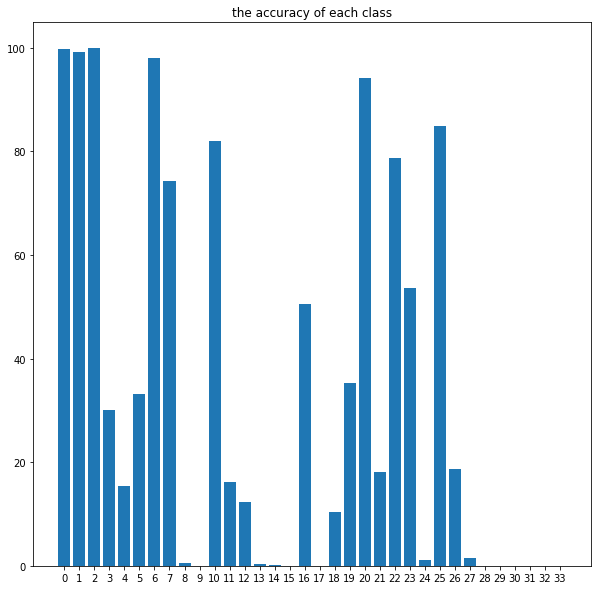

In [23]:
num = 32
num1 = [0]*34
acc = [0]*34
kkk = 0
for image, mask in dataset_val.take(15):
        pred_mask = model.predict(image)
        print(pred_mask.shape)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
    
        plt.figure(figsize=(10, 10))
        kkk = kkk + 1
        for j in range(num):
            arr1 = pred_mask[8]
            arr2 = mask[8]
            arr1 = np.array(arr1)  
            arr2 = np.array(arr2)
            c = confusional_mt(arr2,arr1,34)
            cpa = _cpa(c)
            for i in range(0,34):
                if 0<=cpa[i]<=5:
                    acc[i] = acc[i] + cpa[i]
                    num1[i] = num1[i] + 1


for i in range(0,34):
    if num1[i] != 0:
        acc[i] = acc[i]/num1[i]*100
#show accuracy
accuracy = [0]*34
for i in range(1,33):
    accuracy[i-1] = acc[i]
# print('length of accuracy',len(accuracy))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

classes = ("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31","32","33")

plt.bar(classes, accuracy)
plt.title('the accuracy of each class')

plt.show()


## b. Predictions and visualizations for $(\mu,aleatoric,epistemic)$

In [20]:
def variance(n):
    res = np.empty((128, 256))
    for i in range(127):
        for j in range(255):
            res[i][j] = np.var(n[i, j, :])
    return res

def entropy(pk,axis):  
    S = -np.sum(pk * np.log(pk), axis=axis)
    return S

In [29]:
model = load_model('./model.h5')
count = 0
num = 5

1/1 [==============================] - 0s 387ms/step
image shape (32, 128, 256, 3)
pred_label shape (32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
image shape (32, 128, 256, 3)
pred_label shape (32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
image shape (32, 128, 256, 3)
pred_label shape (32, 128, 256, 34)
1/1 [==============================] - 0s 23ms/step
image shape (32, 128, 256, 3)
pred_label shape (32, 128, 256, 34)
1/1 [==============================] - 0s 22ms/step
image shape (32, 128, 256, 3)
pred_label shape (32, 128, 256, 34)


2023-02-10 14:59:22.987309: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


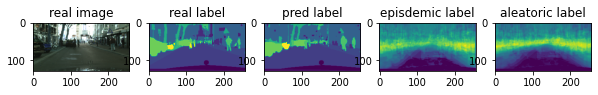

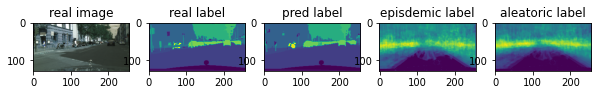

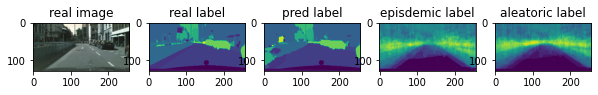

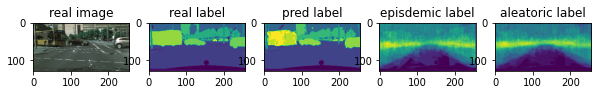

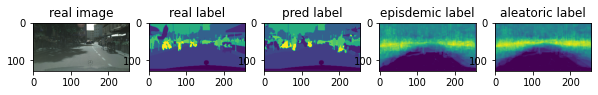

In [30]:
for image, label in dataset_val.take(num):
    concat_pred_label_p = None
    pred_label = model.predict(image)
    
    print('image shape',image.shape)
    print('pred_label shape',pred_label.shape)
    atmp = tf.squeeze(tf.reduce_mean(pred_label,axis=0))
    # print(atmp.shape)
    output = tf.reduce_mean(pred_label,axis=0)
    # print(output.shape)
    aleatoric = entropy(output, axis=-1)
    # print(aleatoric.shape)
    episdemic = tf.reduce_mean(tf.squeeze(np.std(pred_label,axis=0)),axis=-1)
    # print(episdemic.shape)
    pred_label = tf.argmax(pred_label, axis=-1)
    pred_label = pred_label[..., tf.newaxis]
    plt.figure(figsize=(10, 10))
    plt.subplot(5, 5, count*num+1)
    plt.title('real image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[1]))
    plt.subplot(5, 5, count*num+2)
    plt.title('real label')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(label[1]))
    plt.subplot(5, 5, count*num+3)
    plt.title('pred label')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_label[1]))
    plt.subplot(5, 5, count*num+4)
    plt.title('episdemic label')
    plt.imshow(episdemic)
    plt.subplot(5, 5, count*num+5)
    plt.title('aleatoric label')
    plt.imshow(aleatoric)
    count += 1

## c. Comment briefly on how the model’s performance could be improved.

###### Overall performance

The model overall peroformance pretty well, but there are some minor details that cannot be segmented.

###### Ways we tried to improve

We tried several ways to increase the accuarcy, including 
1. adding data augmentation(to be specific, is to delete the car's hood and logo)
2. decreasing the batch size

However, the result shows that the accuarcy not only did not go higher, but instead it went down.  

###### Ways may really help

1. Use other more powerful ways of data augmentation like color augmentation.
2. Change the whole architecture to Bayesian network.
3. Train more epochs.